<a href="https://colab.research.google.com/github/succSeeded/dl-2025/blob/main/hws/week02_autodiff/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework part I

The first problem set contains basic tasks in PyTorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to PyTorch or PyTorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in PyTorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [9]:
# Interactive plots do not work w/o ipympl for some reason...
!pip install -U ipympl -q
from IPython import get_ipython
get_ipython().kernel.do_shutdown(restart=True) # the kernel will be restarted!!!

{'status': 'ok', 'restart': True}

In [1]:
# Allow interactive plots
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

2.8.0+cu126


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword.


__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

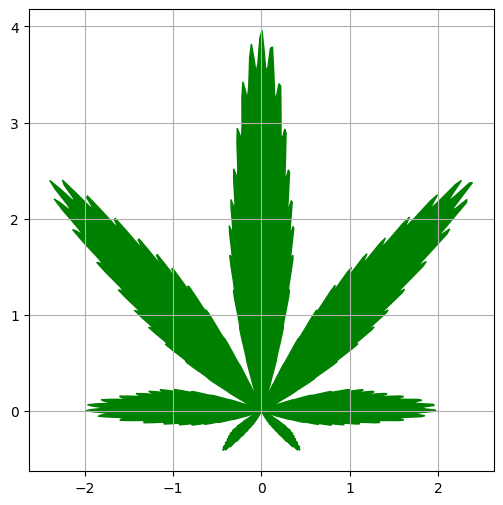

In [3]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1.0 + 0.9 * torch.cos(8.0 * theta)) * (1.0 + 0.1 * torch.cos(24.0 * theta)) * (0.9 + 0.05 * torch.cos(200.0 * theta)) * (1.0 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100 ]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [6]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.

    You can opt to create new tensor or change Z inplace.
    """

    filters = torch.tensor([[1, 1, 1],
                            [1, 0, 1],
                            [1, 1, 1]], dtype=torch.float32, device=device)

    N = torch.nn.functional.conv2d(Z.reshape(1, 1, Z.shape[0], Z.shape[1]), filters.reshape(1, 1, filters.shape[0], filters.shape[1]), stride=1, padding=1)

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive

    return Z


In [7]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor).to(device)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.cpu().numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


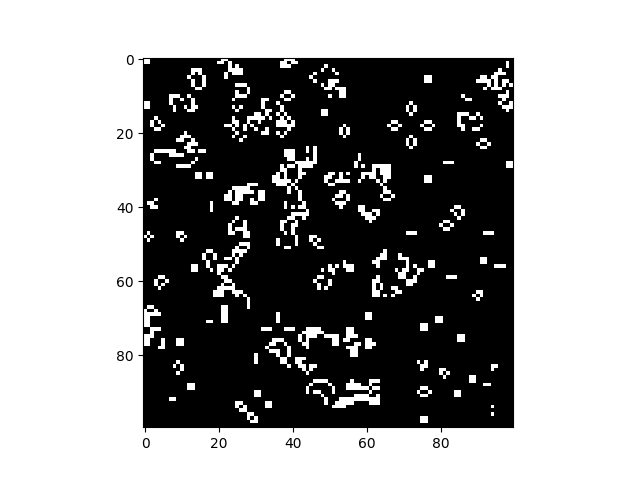

In [24]:
%matplotlib ipympl
plt.ion()

# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor).to(device)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()

for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.cpu().numpy(), cmap='gray')
    fig.canvas.draw() # I think it is supposed to be displayed as a step-by-step
                      # animation, but I am unable to replicate this behaviour?
plt.show()

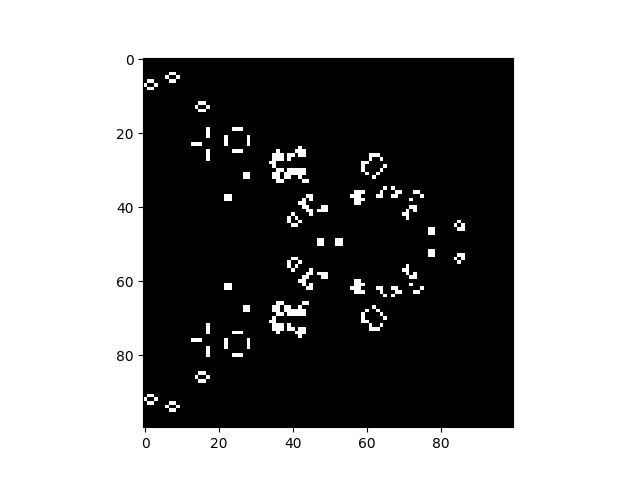

In [25]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor).to(device)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.cpu().numpy(), cmap='gray')
    fig.canvas.draw()

plt.show()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE) and/or [Jupyter Notebook](https://nbviewer.jupyter.org/url/norvig.com/ipython/Life.ipynb)

### Task III: Going deeper
<img src="https://www.meme-arsenal.com/memes/00ad90d844e491aaeb6892515c716710.jpg" width=360>

Your third trial is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve yet another digit recognition problem, but at a greater scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__ .  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [26]:
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week02_autodiff/notmnist.py

In [27]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


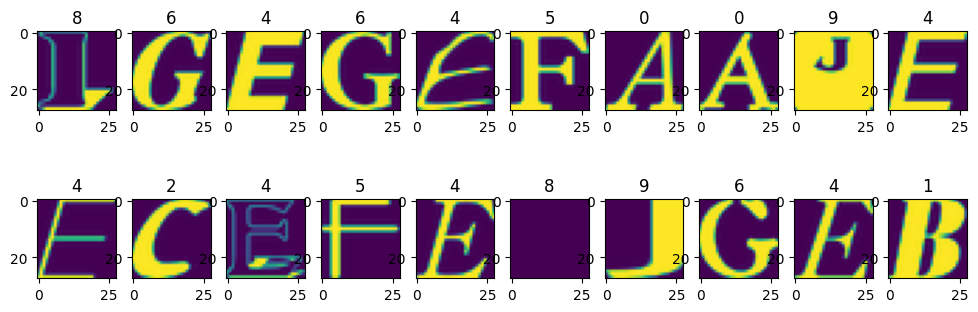

In [32]:
%matplotlib inline
plt.close()
plt.figure(figsize=[12, 4])
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i].reshape([28, 28]))
    plt.title(str(y_train[i]))

In [50]:
import torch

def erf_prime(x: torch.Tensor) -> torch.Tensor:
    return 2.0 / torch.sqrt(torch.pi) * torch.exp(-(x**2))

class my_GELU(torch.nn.Module):
    """
    My implementation of GELU nonlinearity.

    Args:
      approximate: Whether to use approximation or not. (default: `False`)
    """
    def __init__(self, approximate: bool = False):
        super().__init__()
        self.approximate_ = approximate

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        """
        Apply elementwise GELU to [batch, input_units] matrix
        """
        sqrt2 = 1.41421
        if self.approximate_:
            return x * torch.nn.Sigmoid(1.702 * x)
        else:
            return x * 0.5 * (1.0 + torch.erf(x / sqrt2))

    @classmethod
    def grad_(x: torch.Tensor) -> torch.Tensor:
        """
        Gradient of GELU function.

        Args:
            x: point in space where the gradient will be calculated.
        """
        sqrt2 = 1.41421
        return 0.5 * (
                torch.ones_like(x)
                + x * erf_prime(x / sqrt2) / sqrt2
                + torch.erf(x / sqrt2)
            )

    def backward(self, x:torch.Tensor, grad_output:torch.Tensor):
        """
        Compute gradient of loss w.r.t. GELU input
        """
        if self.approximate_:
            return grad_output * (
                torch.nn.Sigmoid(1.702 * x)
                + 1.702 * x * (1.0 - torch.nn.Sigmoid(1.702 * x)) * torch.nn.Sigmoid(1.702 * x)
            )
        else:
            return grad_output * my_GELU.grad_(x)


class my_Linear(torch.nn.Module):
    """
    My implementation of a linear layer.

    Args:
      in_params: number of input features.
      out_params: number of output features.
      bias: whether to use additive bias (default = `False`)
    """
    def __init__(self, in_params: int, out_params: int, bias: bool = False):
        super().__init__()
        self.weights = torch.nn.Parameter(torch.rand(in_params, out_params))
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_params, requires_grad=bias))
        else:
            self.bias = torch.zeros(out_params, requires_grad=bias)

    def forward(self, x):
        return x @ self.weights + self.bias


class my_LogSoftmax(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return torch.log(x) - torch.sum(torch.log(x))

In [54]:
logReg = torch.nn.Sequential(my_Linear(28 * 28, 10, bias=True), my_GELU())
opt = torch.optim.SGD(logReg.parameters())

history = []

for i in range(100):

    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = torch.tensor(X_train[ix], dtype=torch.float32)
    y_batch = torch.tensor(y_train[ix], dtype=torch.float32)

    # predict probabilities
    y_predicted = logReg(x_batch)

    # compute loss
    loss = torch.nn.functional.nll_loss(y_predicted, y_batch)

    # compute gradients
    loss.backward()

    # Adam step
    opt.step()

    # clear gradients
    opt.zero_grad()

    history.append(loss.data.numpy())

    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

RuntimeError: expected scalar type Long but found Float

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.